In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install --upgrade pandas

#!pip install talos
#!pip install statsmodels -U
#!pip install --upgrade pytest

In [3]:
# !ls "drive/My Drive/Colab Notebooks/data"

# Imports, loads , Train/test split and Optimum params
---

In [4]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
data = pd.read_pickle('../data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

Labels assigned to types 

In [6]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

bias - [1 0 0 0]
click - [0 1 0 0]
fake - [0 0 1 0]
truth - [0 0 0 1]


In [7]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1556
Max len title: 14


In [8]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [9]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/valid/test split**

In [10]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [11]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [12]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [13]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

## Optimum Params found with Bayesian Optimization

In [14]:

# #Optimum params for CNN network
# params_cnn = {
#     'lr': 0.23993334664040306,
#     'momentum': 0.30361299021107185,
#     'dropout1': 0.10993063833594595,
#     'dropout2': 0.1586041045258562,
#     'filters1Title': 8,
#     'denseTitle': 42,
#     'filtersContent': 6,
#     'denseContent': 34
# }
params_cnn = {
    'lr': 0.4,
    'momentum': 0.34376395524693715,
    'dropout1': 0.22538075274187744,
    'dropout2': 0.4,
    'filters1Title': 5,
    'denseTitle': 25,
    'filtersContent': 5,
    'denseContent': 28
}

In [15]:
#Some imports...
import tensorflow as tf
import os

from numpy.random import seed
# from tensorflow import set_random_seed

# Convolutional networks

In [16]:
seed(50)
#     set_random_seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [17]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
#

x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(4, activation='softmax')(x)


#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='categorical_crossentropy', metrics=['acc'])
model.compile(k.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 14)]         0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      [(None, 1556)]       0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 14, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_content (Embedding)       (None, 1556, 300)    15000000    content_input[0][0]              
_______________________________________________________________________________________

In [18]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/20
740/740 [==============================] - 325s 439ms/step - loss: 0.6522 - acc: 0.7782 - val_loss: 0.4796 - val_acc: 0.8371
Epoch 2/20
740/740 [==============================] - 325s 439ms/step - loss: 0.4391 - acc: 0.8607 - val_loss: 0.4567 - val_acc: 0.8495
Epoch 3/20
740/740 [==============================] - 332s 448ms/step - loss: 0.3522 - acc: 0.8973 - val_loss: 0.4510 - val_acc: 0.8549
Epoch 4/20
740/740 [==============================] - 349s 472ms/step - loss: 0.2795 - acc: 0.9235 - val_loss: 0.4868 - val_acc: 0.8497


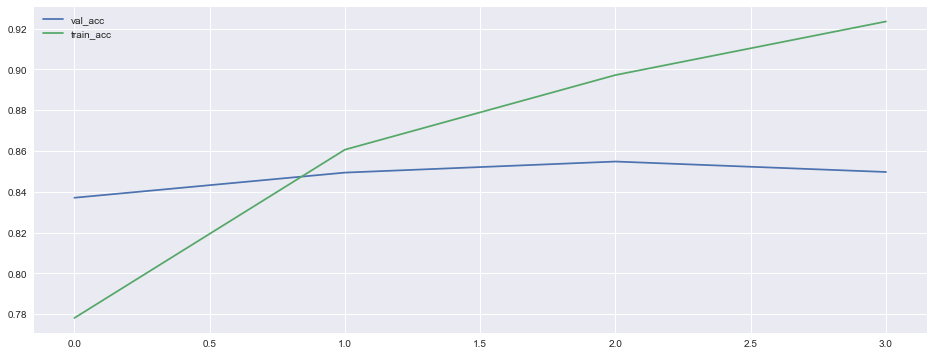

In [19]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

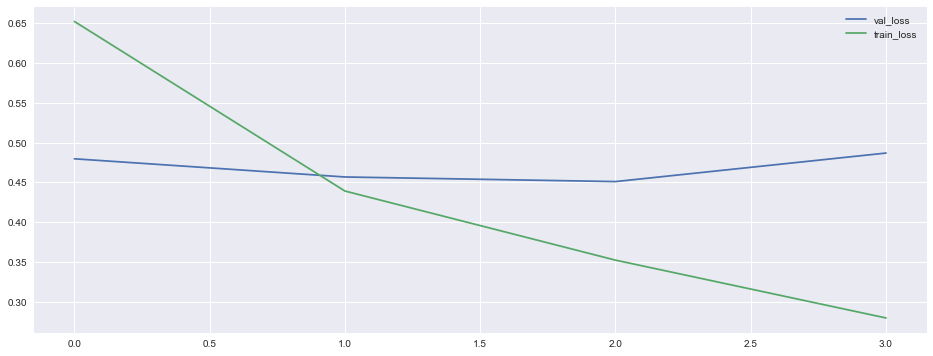

In [20]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [21]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.828421052631579

In [22]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.77      0.83      0.80     13475
           1       0.92      0.86      0.89     14955
           2       0.93      0.89      0.91     14661
           3       0.92      0.74      0.82     14859

   micro avg       0.88      0.83      0.85     57950
   macro avg       0.89      0.83      0.85     57950
weighted avg       0.89      0.83      0.85     57950
 samples avg       0.83      0.83      0.83     57950



C:\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[12123   399   424   529]
 [ 1669 12802   203   281]
 [ 1345   143 12998   175]
 [ 2987   601   312 10959]]


<AxesSubplot:>

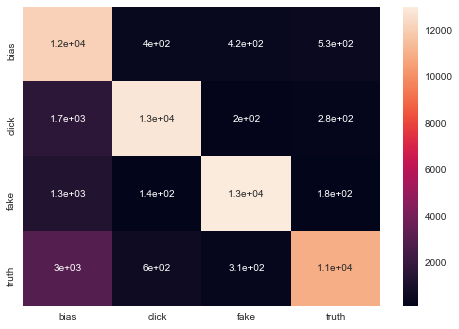

In [23]:
matrix = confusion_matrix(np.array(y_test.tolist()).argmax(axis=1), test_pred.round().argmax(axis=1))
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['bias', 'click', 'fake', 'truth'], index=['bias', 'click', 'fake', 'truth'])
sns.heatmap(df_cm, annot=True)

In [24]:
CONV_PATH = '../weights/conv.h5'
model.save(CONV_PATH)